This notebook shows the training process.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
import torch
import numpy as np
import random

def reset_seed(seed=12):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # gpu vars


In [5]:
from mpl_toolkits.mplot3d import Axes3D
from src.multichannel import *

In [6]:
from fastai2.basics import *
from fastai2.vision.augment import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.data.all import *
from src.customnets import SimpleNet

In [7]:
def listrange(start, end):
    return list(range(start, end))

In [8]:
interp_bands = [98,99] + list(range(153,197)) + list(range(208,230)) + list(range(253,281)) + list(range(336,382))
non_interp_bands = (list(range(0,98)) + list(range(100,153)) + list(range(197,208)) + list(range(231,253)) 
                    + list(range(281,336)) + list(range(383,461)))
non_interp_under_2000nm = (list(range(0,98)) + list(range(100,153)) + list(range(197,208)) + list(range(231,253)) 
                           + list(range(281,337)))
all_bands = list(range(460))
vnir = list(range(186))# + [460]
vnir_nointerp = list(range(0,98)) + list(range(100,153)) + [460]
pca = list(range(30))
selection = non_interp_under_2000nm

In [9]:
 selection = listrange(0,100) + listrange(101, 155) + listrange(195, 209) + listrange(230,255) + listrange(280,337)

# Read data

In [10]:
basedir = Path('data/tree_cubes_10m_fixed/5m')
stats = np.load(str(basedir/'train_stats.npy')).astype(np.float32)

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [12]:
dls = MultiChannelImageDataLoaders.from_shapefile(basedir, shp_fname='train_test.shp', extensions=['.npy'], 
                                                  label_col='species', fn_col='filename', bs=64,
                                                  chans=selection, 
                                                  #valid_pct=0.1, seed=12,
                                                  valid_col='is_test',
                                                  batch_tfms=setup_aug_tfms([
                                                      Normalize.from_stats(*stats[:,selection] / 100),
                                                      ToVolumetric(),
                                                      Dihedral(),
                                                      Brightness(max_lighting=0.2),
                                                      #Contrast(max_lighting=0.1),
                                                      #RandomErasing(p=0.25)
                                                  ]),
                                                  item_tfms=[
                                                      ScaleToFloatTensor(div=100)],
                                                  #num_workers=0
                                                 )


In [13]:
vmin, vmax = (0.05222363963723183, 5.074245080947874)

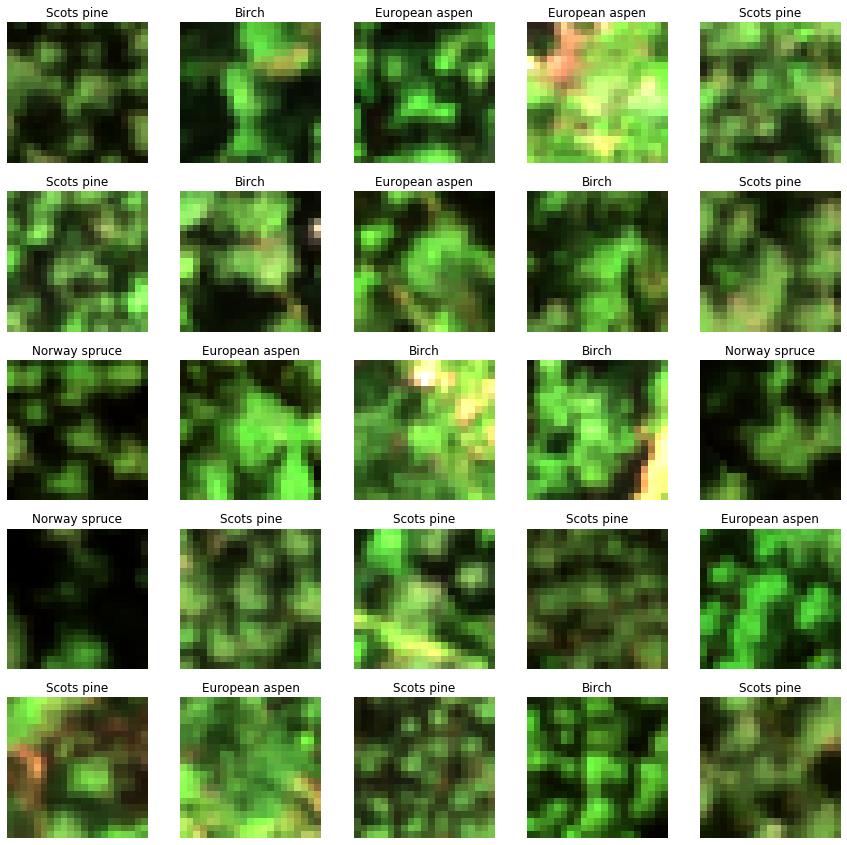

In [14]:
dls.show_batch(channels=[82,50,29], scale=True, scale_axis=None, max_n=25, vmin=vmin, vmax=vmax)

In [15]:
dls.one_batch()

(MultiChannelTensorImage size=64x1x250x21x21,
 TensorCategory([3, 2, 0, 0, 3, 2, 3, 1, 3, 3, 0, 2, 3, 2, 0, 2, 0, 0, 0, 3, 3, 3, 3, 2,
         0, 1, 0, 1, 1, 2, 3, 2, 3, 3, 2, 3, 2, 2, 1, 1, 0, 3, 1, 0, 3, 2, 1, 0,
         3, 2, 3, 1, 0, 3, 3, 2, 2, 3, 3, 2, 3, 1, 3, 1], device='cuda:0'))

# Define model

## Some not-so-clean definitions

In [16]:
def _conv_func(ndim=2, transpose=False):
    "Return the proper conv `ndim` function, potentially `transposed`."
    assert 1 <= ndim <=3
    return getattr(nn, f'Conv{"Transpose" if transpose else ""}{ndim}d')

In [17]:
class ConvLayer2(nn.Sequential):
    "Create a sequence of convolutional (`ni` to `nf`), ReLU (if `use_activ`) and `norm_type` layers."
    def __init__(self, ni, nf, ks=3, stride=1, padding=None, bias=None, ndim=2, norm_type=NormType.Batch, bn_1st=True,
                 act_cls=defaults.activation, transpose=False, init='auto', xtra=None, bias_std=0.01, **kwargs):
        if padding is None:
            padding = [1 for _ in range(len(ks))]
            for k in range(len(ks)):
                padding[k]= ((ks[k]-1)//2 if not transpose else 0)
        bn = norm_type in (NormType.Batch, NormType.BatchZero)
        inn = norm_type in (NormType.Instance, NormType.InstanceZero)
        if bias is None: bias = not (bn or inn)
        conv_func = _conv_func(ndim, transpose=transpose)
        conv = conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding, **kwargs)
        act = None if act_cls is None else act_cls()
        init_linear(conv, act, init=init, bias_std=bias_std)
        if   norm_type==NormType.Weight:   conv = weight_norm(conv)
        elif norm_type==NormType.Spectral: conv = spectral_norm(conv)
        layers = [conv]
        act_bn = []
        if act is not None: act_bn.append(act)
        if bn: act_bn.append(BatchNorm(nf, norm_type=norm_type, ndim=ndim))
        if inn: act_bn.append(InstanceNorm(nf, norm_type=norm_type, ndim=ndim))
        if bn_1st: act_bn.reverse()
        layers += act_bn
        if xtra: layers.append(xtra)
        super().__init__(*layers)


In [18]:
def get_simple_3d_resnet(lrs, krns, activ, stride, exps, pad=0, bias=False):
    conv = [ConvLayer2(lrs[0], lrs[1], ks=krns[0], ndim=3, stride=strides[0], padding=1)]
    net = [ResBlock(exps[i], lrs[i], lrs[i+1], ks=krns[i], ndim=3, stride=strides[i]) for i in range(1, len(krns))]
    return SequentialEx(*conv+net)

In [19]:
def get_simple_3dcnn(lrs, krns, activ, stride, pad=0,bias=False):
    net = [ConvLayer2(lrs[i], lrs[i+1], ks=krns[i], ndim=3, stride=strides[i], padding=pad) for i in range(len(krns))]
    return nn.Sequential(*net)

In [20]:
def get_simple_3dcnn_pool(lrs, krns, activ, stride, pad=0,bias=False):
    net = [nn.Sequential(
           nn.Conv3d(lrs[i], lrs[i+1], kernel_size=krns[i], padding=pad, stride=stride[i], bias=bias),
           nn.BatchNorm3d(lrs[i+1]),
           activ(),
           #nn.MaxPool3d(2)
    ) for i in range(len(krns))]
    return nn.Sequential(*net)

## Define network

TODO: collect params to some file

In [22]:
#activ = Mish
activ = nn.ReLU
lrs = [1,
       32,
       32, # Extra for 5m window
       64,
       64,
       128] # define our layers
krns = [(10,3,3),
        (5,3,3),
        (3,3,3),
        (3,3,3),
        (3,3,3)
       ] 
strides = [(2,1,1), 
           (2,2,2),
           (2,1,1), 
           (1,2,2), # extra for 5m
           (1,1,1)]
features =  get_simple_3dcnn_pool(lrs, krns, activ, strides)


In [25]:
features

Sequential(
  (0): Sequential(
    (0): Conv3d(1, 32, kernel_size=(10, 3, 3), stride=(2, 1, 1), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv3d(32, 32, kernel_size=(5, 3, 3), stride=(2, 2, 2), bias=False)
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 2, 2), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
from torchsummary import summary
summary(features.cuda(), input_size=(1,250,21,21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 121, 19, 19]           2,880
       BatchNorm3d-2      [-1, 32, 121, 19, 19]              64
              ReLU-3      [-1, 32, 121, 19, 19]               0
            Conv3d-4         [-1, 32, 59, 9, 9]          46,080
       BatchNorm3d-5         [-1, 32, 59, 9, 9]              64
              ReLU-6         [-1, 32, 59, 9, 9]               0
            Conv3d-7         [-1, 64, 29, 7, 7]          55,296
       BatchNorm3d-8         [-1, 64, 29, 7, 7]             128
              ReLU-9         [-1, 64, 29, 7, 7]               0
           Conv3d-10         [-1, 64, 27, 3, 3]         110,592
      BatchNorm3d-11         [-1, 64, 27, 3, 3]             128
             ReLU-12         [-1, 64, 27, 3, 3]               0
           Conv3d-13        [-1, 128, 25, 1, 1]         221,184
      BatchNorm3d-14        [-1, 128, 2

In [27]:
flat_shp = lrs[-1] * 25
dropout_pct = 0.5
classifier = nn.Sequential(
                           nn.Linear(flat_shp, 512, bias=False), 
                           activ(), 
                           nn.Dropout(dropout_pct), 
                           nn.BatchNorm1d(512), 
                           nn.Linear(512, dls.c))

In [28]:
flat_shp

3200

In [29]:
model = SimpleNet(features, classifier)

In [30]:
from torchsummary import summary
summary(model.cuda(), input_size=(1,250,21,21))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 32, 121, 19, 19]           2,880
       BatchNorm3d-2      [-1, 32, 121, 19, 19]              64
              ReLU-3      [-1, 32, 121, 19, 19]               0
            Conv3d-4         [-1, 32, 59, 9, 9]          46,080
       BatchNorm3d-5         [-1, 32, 59, 9, 9]              64
              ReLU-6         [-1, 32, 59, 9, 9]               0
            Conv3d-7         [-1, 64, 29, 7, 7]          55,296
       BatchNorm3d-8         [-1, 64, 29, 7, 7]             128
              ReLU-9         [-1, 64, 29, 7, 7]               0
           Conv3d-10         [-1, 64, 27, 3, 3]         110,592
      BatchNorm3d-11         [-1, 64, 27, 3, 3]             128
             ReLU-12         [-1, 64, 27, 3, 3]               0
           Conv3d-13        [-1, 128, 25, 1, 1]         221,184
      BatchNorm3d-14        [-1, 128, 2

In [31]:
from fastai2.callback.all import *

In [32]:
import sklearn.metrics as skm

In [33]:
def CohenKappaFix(axis=-1, labels=None, weights=None, sample_weight=None):
    "Cohen kappa for single-label classification problems"
    return skm_to_fastai(skm.cohen_kappa_score, axis=axis,
                         sample_weight=sample_weight, labels=labels, weights=weights)

# Train model

In [34]:
reset_seed(12)
f1 = F1Score(average='macro')
precision = Precision(average='macro')
recall = Recall(average='macro')
kappa = CohenKappaFix()
mixup = MixUp()
learn = Learner(dls, model, 
                loss_func=LabelSmoothingCrossEntropy(), 
                path=Path('fastai_models/5m_relu_fixed'), model_dir='models',
                metrics=[accuracy,  precision, recall, f1, kappa], 
                opt_func=partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8),
                cbs=[
                    ShowGraphCallback(), 
                    SaveModelCallback(monitor='f1_score'),
                    mixup
                ])

In [35]:
apply_init(learn.model)

In [36]:
learn.summary()

SimpleNet (Input shape: ['64 x 1 x 250 x 21 x 21'])
Layer (type)         Output Shape         Param #    Trainable 
Conv3d               64 x 32 x 121 x 19   2,880      True      
________________________________________________________________
BatchNorm3d          64 x 32 x 121 x 19   64         True      
________________________________________________________________
ReLU                 64 x 32 x 121 x 19   0          False     
________________________________________________________________
Conv3d               64 x 32 x 59 x 9 x   46,080     True      
________________________________________________________________
BatchNorm3d          64 x 32 x 59 x 9 x   64         True      
________________________________________________________________
ReLU                 64 x 32 x 59 x 9 x   0          False     
________________________________________________________________
Conv3d               64 x 64 x 29 x 7 x   55,296     True      
______________________________________________

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0004786300996784121)

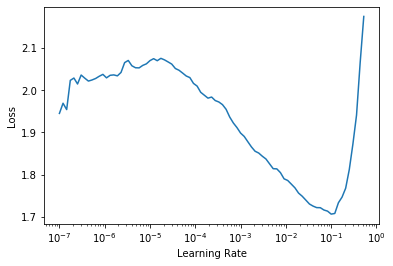

In [37]:
learn.lr_find(suggestions=True)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,cohen_kappa_score,time
0,1.813296,1.314503,0.548944,0.505198,0.479385,0.478025,0.341648,00:10
1,1.657228,1.215115,0.595010,0.575849,0.539170,0.542416,0.411728,00:08
2,1.555018,1.179019,0.596929,0.553485,0.533257,0.536298,0.416539,00:08
3,1.498796,1.164119,0.602687,0.555165,0.545972,0.544253,0.430499,00:08
4,1.450574,1.077839,0.625720,0.580126,0.572568,0.571024,0.466068,00:08
5,1.403990,1.029019,0.667946,0.641316,0.612413,0.608777,0.520230,00:08
6,1.364511,1.011126,0.662188,0.605095,0.595482,0.594193,0.516310,00:08
7,1.342782,0.968902,0.660269,0.628977,0.595565,0.598913,0.509421,00:08
8,1.312583,0.968904,0.725528,0.719381,0.672781,0.684874,0.602636,00:08
9,1.284514,1.006075,0.710173,0.733090,0.660750,0.656703,0.582961,00:08


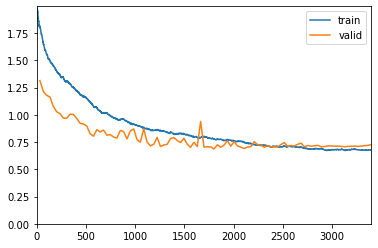

In [38]:
learn.fit_one_cycle(100, lr_max=1e-3)

In [39]:
learn.export()

# See results

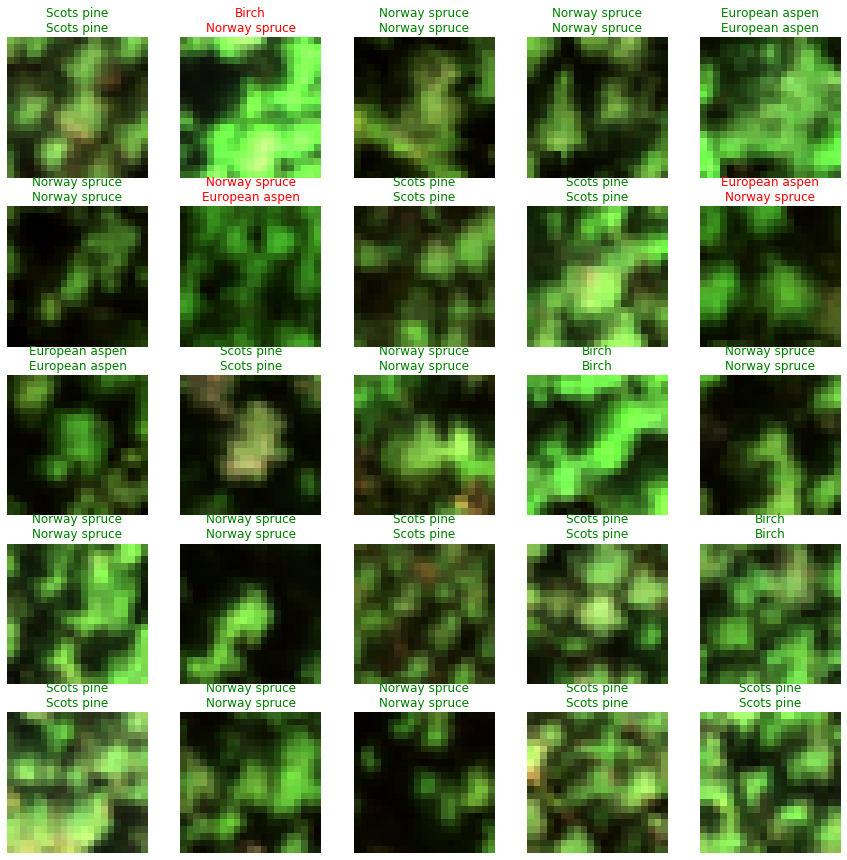

In [40]:
learn.show_results(channels=[82,50,29], scale=True, max_n=25, scale_axis=None, vmin=vmin, vmax=vmax)

In [41]:
interp = ClassificationInterpretation.from_learner(learn)

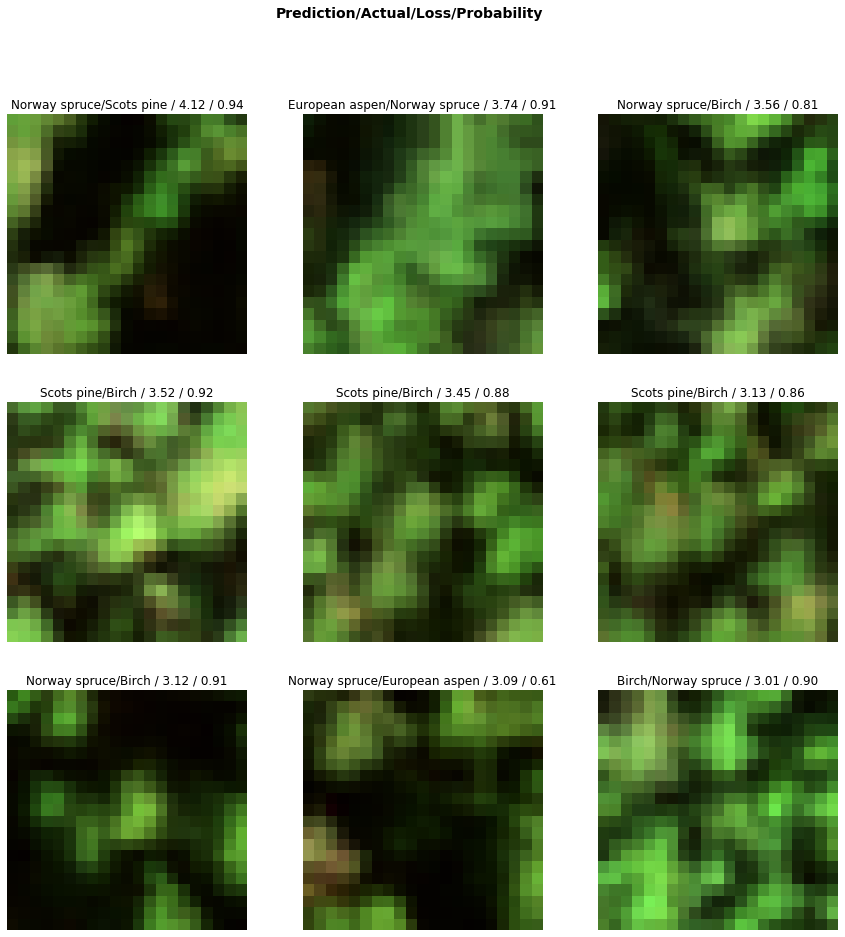

In [42]:
interp.plot_top_losses(9, channels=[82,50,29], scale=True, scale_axis=None, largest=True, vmin=vmin, vmax=vmax,
                       figsize=(15,15))

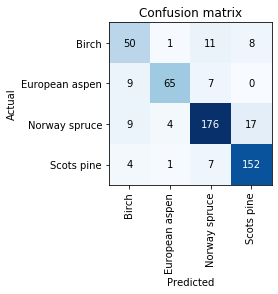

In [43]:
interp.plot_confusion_matrix()

In [44]:
interp.print_classification_report()

                precision    recall  f1-score   support

         Birch       0.69      0.71      0.70        70
European aspen       0.92      0.80      0.86        81
 Norway spruce       0.88      0.85      0.86       206
    Scots pine       0.86      0.93      0.89       164

      accuracy                           0.85       521
     macro avg       0.84      0.82      0.83       521
  weighted avg       0.85      0.85      0.85       521

